Feature importances:
                        Feature  Importance
5                     src_bytes    0.154657
6                     dst_bytes    0.138015
34       dst_host_same_srv_rate    0.071176
3                       service    0.059652
35       dst_host_diff_srv_rate    0.058795
4                          flag    0.054413
33           dst_host_srv_count    0.050919
40         dst_host_rerror_rate    0.045669
12                    logged_in    0.040251
41     dst_host_srv_rerror_rate    0.035893
1                      duration    0.033289
36  dst_host_same_src_port_rate    0.026924
2                 protocol_type    0.026902
24                    srv_count    0.025969
23                        count    0.023937
32               dst_host_count    0.017974
29                same_srv_rate    0.017088
30                diff_srv_rate    0.016826
10                          hot    0.015973
37  dst_host_srv_diff_host_rate    0.012852
31           srv_diff_host_rate    0.012360
27         

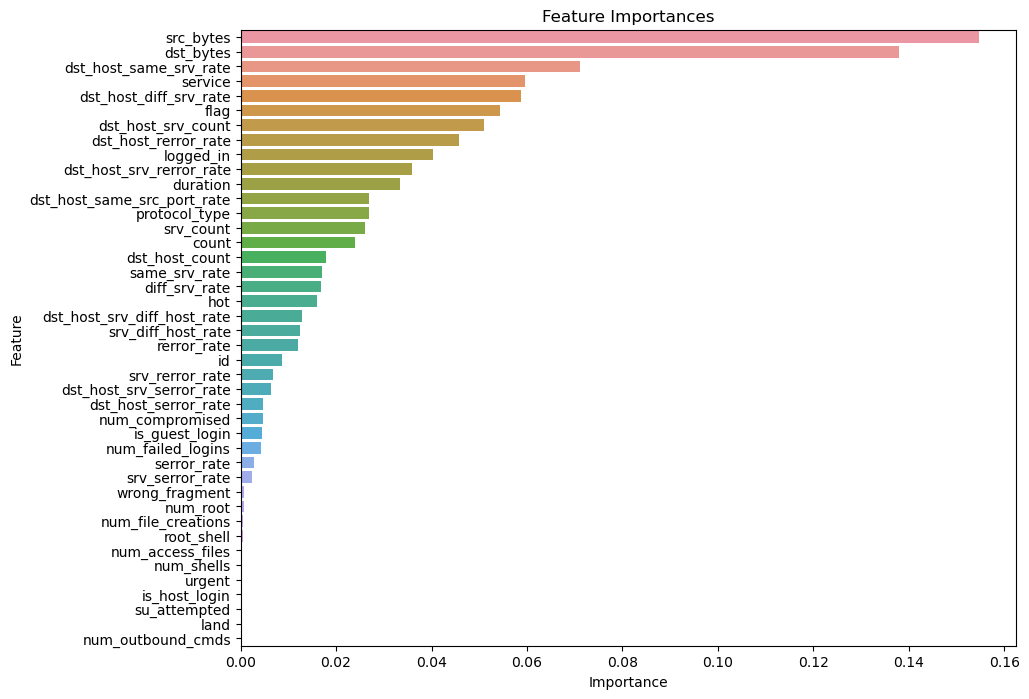


Selected features:
src_bytes
dst_bytes
dst_host_same_srv_rate
service
dst_host_diff_srv_rate
flag
dst_host_srv_count
dst_host_rerror_rate
logged_in
dst_host_srv_rerror_rate


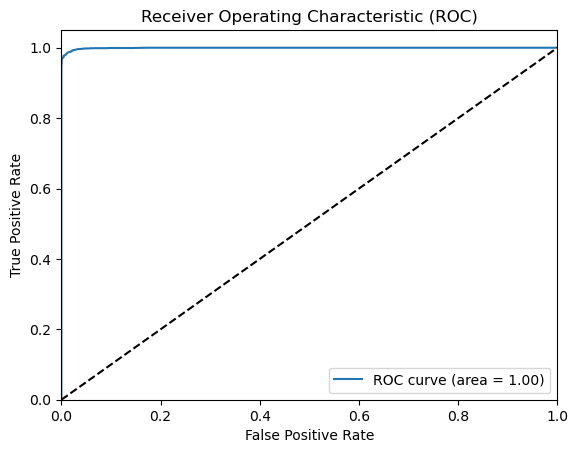

Stability Score: 0.986426338394222
Accuracy: 0.9863985807214666
F1-Score: 0.9864040283473643
Recall: 0.9863985807214666
Precision: 0.9864270121762745
ROC AUC: 0.9993617679304463


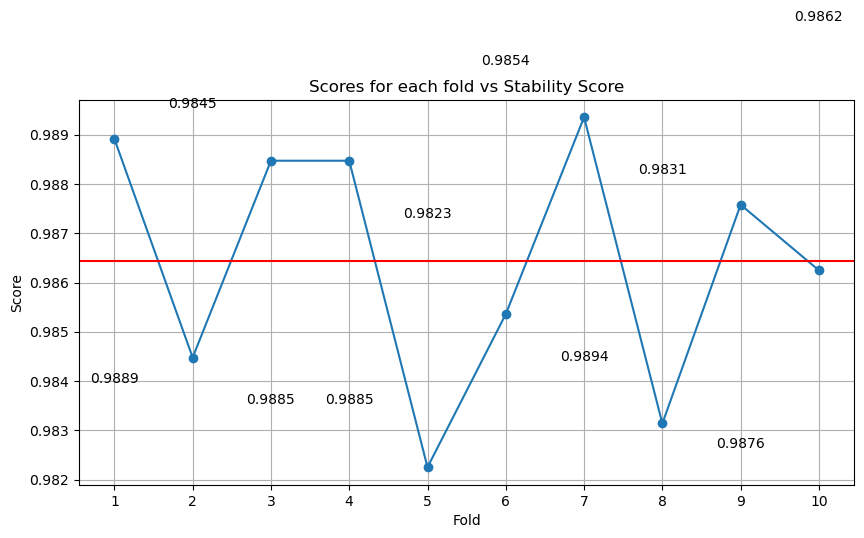

In [1]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
import matplotlib.pyplot as plt
# Import additional libraries
import seaborn as sns
from sklearn.metrics import roc_curve

# Function for preprocessing data
def preprocessing(file_path, target_column):
    # Load data from csv file
    data = pd.read_csv(file_path)
    
    # Store the feature names
    feature_names = data.columns.tolist()
    feature_names.remove(target_column)
    
    # Separate target from the rest of the data
    target = data[target_column]
    data = data.drop(target_column, axis=1)
    
    # Handle categorical variables via Label Encoding
    label_encoder = LabelEncoder()
    for column in data.columns:
        if data[column].dtype == 'object':
            data[column] = label_encoder.fit_transform(data[column])

    # Scale the data
    scaler = StandardScaler()
    preprocessed_data = scaler.fit_transform(data)
    
    return preprocessed_data, target, feature_names

# Step B: Gini Index Calculation and Feature Ranking
def calculate_gini_index(preprocessed_data, target, k, feature_names):
    clf = RandomForestClassifier()
    clf.fit(preprocessed_data, target)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1][:k]

    # Create a DataFrame of feature importances
    importances_df = pd.DataFrame({
        'Feature': np.array(feature_names),
        'Importance': importances
    })

    # Sort the DataFrame by importance
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    # Print feature importances
    print("Feature importances:")
    print(importances_df)

    # Visualize feature importances
    plt.figure(figsize=(10,8))
    sns.barplot(x='Importance', y='Feature', data=importances_df)
    plt.title('Feature Importances')
    plt.show()

    # Print selected features
    print("\nSelected features:")
    for i in indices:
        print(feature_names[i])

    return indices

# Step D: Feature Interaction Analysis
def feature_interaction(preprocessed_data, indices):
    combinations_of_features = list(combinations(indices, 2))
    for (feature1, feature2) in combinations_of_features:
        interaction_term = preprocessed_data[:, feature1] * preprocessed_data[:, feature2]
        preprocessed_data = np.column_stack((preprocessed_data, interaction_term))
    return preprocessed_data

# Step E: Stability Analysis
def stability_analysis(preprocessed_data, target, folds):
    clf = RandomForestClassifier()
    cv_scores = cross_val_score(clf, preprocessed_data, target, cv=folds)
    stability_score = np.mean(cv_scores)
    return cv_scores, stability_score

# Step F: Model Training and Evaluation
def model_training(preprocessed_data, target):
    X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, target, test_size=0.3, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, f1, recall, precision, roc_auc


# The BukaGini Algorithm
def bukagini_algorithm(file_path, target_column, k, folds):
    preprocessed_data, target, feature_names = preprocessing(file_path, target_column)
    indices = calculate_gini_index(preprocessed_data, target, k, feature_names)
    preprocessed_data = feature_interaction(preprocessed_data, indices)
    cv_scores, stability_score = stability_analysis(preprocessed_data, target, folds)
    accuracy, f1, recall, precision, roc_auc = model_training(preprocessed_data, target)
    print(f"Stability Score: {stability_score}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"ROC AUC: {roc_auc}")

    # Plotting the scores for each fold
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, folds+1), cv_scores, marker='o', label='Fold Score')
    plt.axhline(y=stability_score, color='r', linestyle='-', label='Stability Score')
    for i, score in enumerate(cv_scores, 1):
        # Adjust vertical offset for text annotation to be closer to the node
        offset = 0.005 if score < stability_score else -0.005
        plt.text(i, score + offset, f"{score:.4f}", ha='center', va='bottom')
    plt.title('Scores for each fold vs Stability Score')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(range(1, folds+1))
    plt.grid(True)
    # plt.legend()  # Hiding the legend as per reviewer's suggestion
    plt.show()





""" 
UNSW_NB15
file_path = 'D:/ML_LAB/UNSW_NB15/UNSW_NB15_training-set.csv'
target_column = 'label'
#WUSTL EHMS
file_path = 'D:/ML_LAB/IoMT/IoMT.csv' target_column = 'label'
#WSN-DS
file_path = 'D:/ML_LAB/Wireless/WSN-DS/WSN-DS.csv' target_column = 'label'

"""
file_path = 'D:/ML_LAB/NSLKDD/KDD.csv' 
target_column = 'class'
k = 10
folds = 10
bukagini_algorithm(file_path, target_column, k, folds)
